# About

In this project, we are using a [dataset](https://www.kaggle.com/datasets/henryshan/2023-data-scientists-salary/data) from Kaggle.

The aim of this project is to build a model that predicts the salary of a Data Scientist based on attributes such as:
- experience level
- employment type
- job title
- remote ratio
- company location
- company size

## A - Data preprocessing

The data preprocessing section includes:
- Dropping unecessary features.
- Renaming column values.
- Checking for missing values.
- Analyzing data distribution.
- Encoding categorical data.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from autogluon.tabular import TabularPredictor

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV # for hyperparameter tuning

from catboost import CatBoostRegressor
from sklearn.ensemble import ExtraTreesRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor

c:\Users\Haingo\anaconda3\Lib\site-packages\dask\dataframe\_pyarrow_compat.py:17: FutureWarning: Minimal version of pyarrow will soon be increased to 14.0.1. You are using 13.0.0. Please consider upgrading.
  warnings.warn(


In [2]:
salary_data = pd.read_csv('ds_salaries.csv')
salary_data

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,2023,SE,FT,Principal Data Scientist,80000,EUR,85847,ES,100,ES,L
1,2023,MI,CT,ML Engineer,30000,USD,30000,US,100,US,S
2,2023,MI,CT,ML Engineer,25500,USD,25500,US,100,US,S
3,2023,SE,FT,Data Scientist,175000,USD,175000,CA,100,CA,M
4,2023,SE,FT,Data Scientist,120000,USD,120000,CA,100,CA,M
...,...,...,...,...,...,...,...,...,...,...,...
3750,2020,SE,FT,Data Scientist,412000,USD,412000,US,100,US,L
3751,2021,MI,FT,Principal Data Scientist,151000,USD,151000,US,100,US,L
3752,2020,EN,FT,Data Scientist,105000,USD,105000,US,100,US,S
3753,2020,EN,CT,Business Data Analyst,100000,USD,100000,US,100,US,L


#### Display info about the dataset

In [3]:
salary_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3755 entries, 0 to 3754
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   work_year           3755 non-null   int64 
 1   experience_level    3755 non-null   object
 2   employment_type     3755 non-null   object
 3   job_title           3755 non-null   object
 4   salary              3755 non-null   int64 
 5   salary_currency     3755 non-null   object
 6   salary_in_usd       3755 non-null   int64 
 7   employee_residence  3755 non-null   object
 8   remote_ratio        3755 non-null   int64 
 9   company_location    3755 non-null   object
 10  company_size        3755 non-null   object
dtypes: int64(4), object(7)
memory usage: 322.8+ KB


The dataset contains 11 columns. The `salary_in_usd` will be the label of the model that we are going to build. Therefore we can drop the columns `salary` and the `salary_currency` columns to avoid redundancy and unecessary features.

We will also drop the `employee_residence` feature because it does not represent all location possibilies.


In [4]:
salary_data.drop(['salary', 'salary_currency', 'employee_residence'], axis=1, inplace=True)
salary_data.columns

Index(['work_year', 'experience_level', 'employment_type', 'job_title',
       'salary_in_usd', 'remote_ratio', 'company_location', 'company_size'],
      dtype='object')

WE will only use keep data gathered in 2023, and drop the work_year column.

In [5]:
salary_data_2023 = salary_data[salary_data['work_year'] == 2023].copy()
salary_data = salary_data_2023
salary_data.shape

(1785, 8)

In [6]:
salary_data_2023.drop('work_year', axis=1, inplace=True)
salary_data

,experience_level,employment_type,job_title,salary_in_usd,remote_ratio,company_location,company_size
0,SE,FT,Principal Data Scientist,85847,100,ES,L
1,MI,CT,ML Engineer,30000,100,US,S
2,MI,CT,ML Engineer,25500,100,US,S
3,SE,FT,Data Scientist,175000,100,CA,M
4,SE,FT,Data Scientist,120000,100,CA,M
...,...,...,...,...,...,...,...
1815,SE,FT,Machine Learning Engineer,134500,0,US,L
1817,MI,FT,Data Scientist,130000,0,US,M
1818,MI,FT,Data Scientist,90000,0,US,M
1819,EN,FT,Data Engineer,160000,0,US,M


##### Rename the values in experience_level and employment_type

In [7]:
experience_level_mapping = {
    'SE': 'Senior',
    'MI': 'Mid-level',
    'EN': 'Entry-level',
    'EX': 'Executive'
}

salary_data['experience_level'] = salary_data['experience_level'].replace(experience_level_mapping )
salary_data

,experience_level,employment_type,job_title,salary_in_usd,remote_ratio,company_location,company_size
0,Senior,FT,Principal Data Scientist,85847,100,ES,L
1,Mid-level,CT,ML Engineer,30000,100,US,S
2,Mid-level,CT,ML Engineer,25500,100,US,S
3,Senior,FT,Data Scientist,175000,100,CA,M
4,Senior,FT,Data Scientist,120000,100,CA,M
...,...,...,...,...,...,...,...
1815,Senior,FT,Machine Learning Engineer,134500,0,US,L
1817,Mid-level,FT,Data Scientist,130000,0,US,M
1818,Mid-level,FT,Data Scientist,90000,0,US,M
1819,Entry-level,FT,Data Engineer,160000,0,US,M


In [8]:
employment_type_mapping = {
    'FT': 'Full-time',
    'PT': 'Part-time',
    'CT': 'Contract',
    'FL': 'Freelance'
}

salary_data['employment_type'] = salary_data['employment_type'].replace(employment_type_mapping)
salary_data

,experience_level,employment_type,job_title,salary_in_usd,remote_ratio,company_location,company_size
0,Senior,Full-time,Principal Data Scientist,85847,100,ES,L
1,Mid-level,Contract,ML Engineer,30000,100,US,S
2,Mid-level,Contract,ML Engineer,25500,100,US,S
3,Senior,Full-time,Data Scientist,175000,100,CA,M
4,Senior,Full-time,Data Scientist,120000,100,CA,M
...,...,...,...,...,...,...,...
1815,Senior,Full-time,Machine Learning Engineer,134500,0,US,L
1817,Mid-level,Full-time,Data Scientist,130000,0,US,M
1818,Mid-level,Full-time,Data Scientist,90000,0,US,M
1819,Entry-level,Full-time,Data Engineer,160000,0,US,M


In [9]:
company_size_mapping = {
    'L': 'Large',
    'M': 'Medium',
    'S': 'Small',
}

salary_data['company_size'] = salary_data['company_size'].replace(company_size_mapping)
salary_data

,experience_level,employment_type,job_title,salary_in_usd,remote_ratio,company_location,company_size
0,Senior,Full-time,Principal Data Scientist,85847,100,ES,Large
1,Mid-level,Contract,ML Engineer,30000,100,US,Small
2,Mid-level,Contract,ML Engineer,25500,100,US,Small
3,Senior,Full-time,Data Scientist,175000,100,CA,Medium
4,Senior,Full-time,Data Scientist,120000,100,CA,Medium
...,...,...,...,...,...,...,...
1815,Senior,Full-time,Machine Learning Engineer,134500,0,US,Large
1817,Mid-level,Full-time,Data Scientist,130000,0,US,Medium
1818,Mid-level,Full-time,Data Scientist,90000,0,US,Medium
1819,Entry-level,Full-time,Data Engineer,160000,0,US,Medium


#### Checking for missing values

In [10]:
salary_data.isnull().sum()

experience_level    0
employment_type     0
job_title           0
salary_in_usd       0
remote_ratio        0
company_location    0
company_size        0
dtype: int64

There aren't any missing values in the dataset.

#### Analyzing data distribution

#### Experience level, employment type, remote ratio, and company size

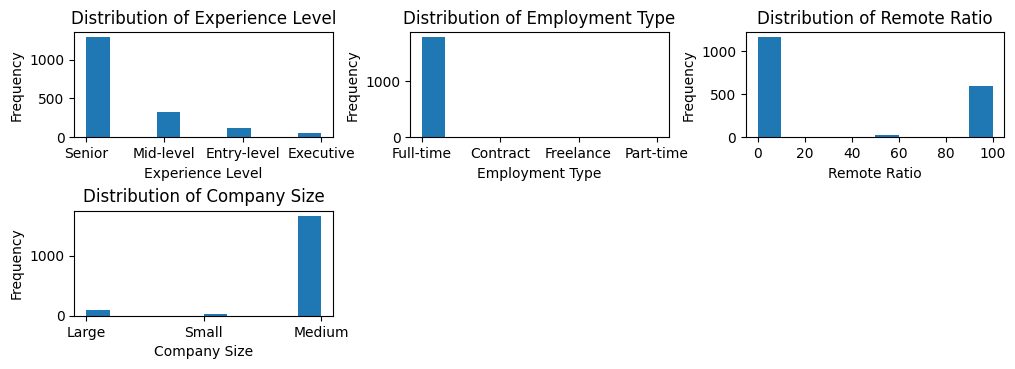

In [11]:
# Set the figure size
plt.figure(figsize=(12, 6))

# Create subplots with 3 plots in the first row
plt.subplot(3, 3, 1)
plt.hist(salary_data['experience_level'])
plt.xlabel('Experience Level')
plt.ylabel('Frequency')
plt.title('Distribution of Experience Level')

plt.subplot(3, 3, 2)
plt.hist(salary_data['employment_type'])
plt.xlabel('Employment Type')
plt.ylabel('Frequency')
plt.title('Distribution of Employment Type')

plt.subplot(3, 3, 3)
plt.hist(salary_data['remote_ratio'])
plt.xlabel('Remote Ratio')
plt.ylabel('Frequency')
plt.title('Distribution of Remote Ratio')

plt.subplot(3, 3, 4)
plt.hist(salary_data['company_size'])
plt.xlabel('Company Size')
plt.ylabel('Frequency')
plt.title('Distribution of Company Size')

# Adjust the spacing between subplots
plt.subplots_adjust(wspace=0.3, hspace=0.7)

# Show the plots
plt.show()

1. Experience level: most of the experience levels in this dataset are SE (senior) level, followed by MI (Mid-level/Intermidiate), EN (Entry-level), then EX (Executives).

1. Employment type: most of the jobs in the dataset are FT (Full time) jobs, with lower values for CT (contract), FL (freelance) and PT (Part-time).

1. Remote ratio: most of the jobs in the dataset are on-site, followed by fully-remote, then hybrid.

1. Distribution of company size: the majority of the companies are medium-size, followed by large companies, then small companies.

#### Company location

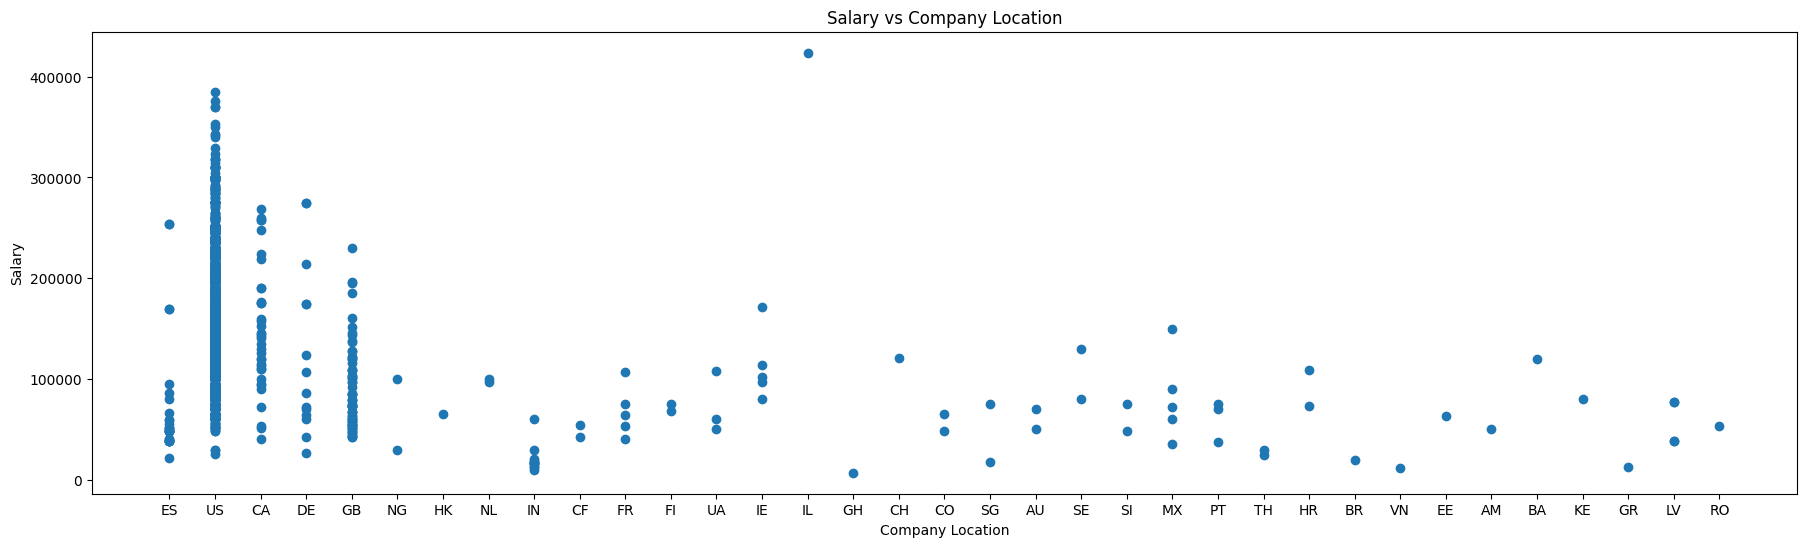

In [12]:
plt.figure(figsize=(22, 6))
plt.scatter(salary_data['company_location'], salary_data['salary_in_usd'])
plt.xlabel('Company Location')
plt.ylabel('Salary')
plt.title('Salary vs Company Location')
plt.show()

In [13]:
salary_data['company_location'].value_counts()[:20]

company_location
US    1570
GB      66
CA      36
ES      28
DE      14
IN      12
FR       5
MX       5
IE       5
LV       4
UA       3
PT       3
HR       2
TH       2
SG       2
SI       2
SE       2
AU       2
CO       2
FI       2
Name: count, dtype: int64

The majority of the companies are located in the United States, Great Britain, Canada, Spain, India, Denmark, and France. We will categorize the rest of the countries as "Other".

In [14]:
countries_to_categorize = ['US', 'GB', 'CA', 'ES', 'IN', 'DE', 'FR']

salary_data['company_location'] = np.where(~salary_data['company_location'].isin(countries_to_categorize), 'Other', salary_data['company_location'])

salary_data['company_location']


0       ES
1       US
2       US
3       CA
4       CA
        ..
1815    US
1817    US
1818    US
1819    US
1820    US
Name: company_location, Length: 1785, dtype: object

#### Job title

<Axes: xlabel='job_title'>

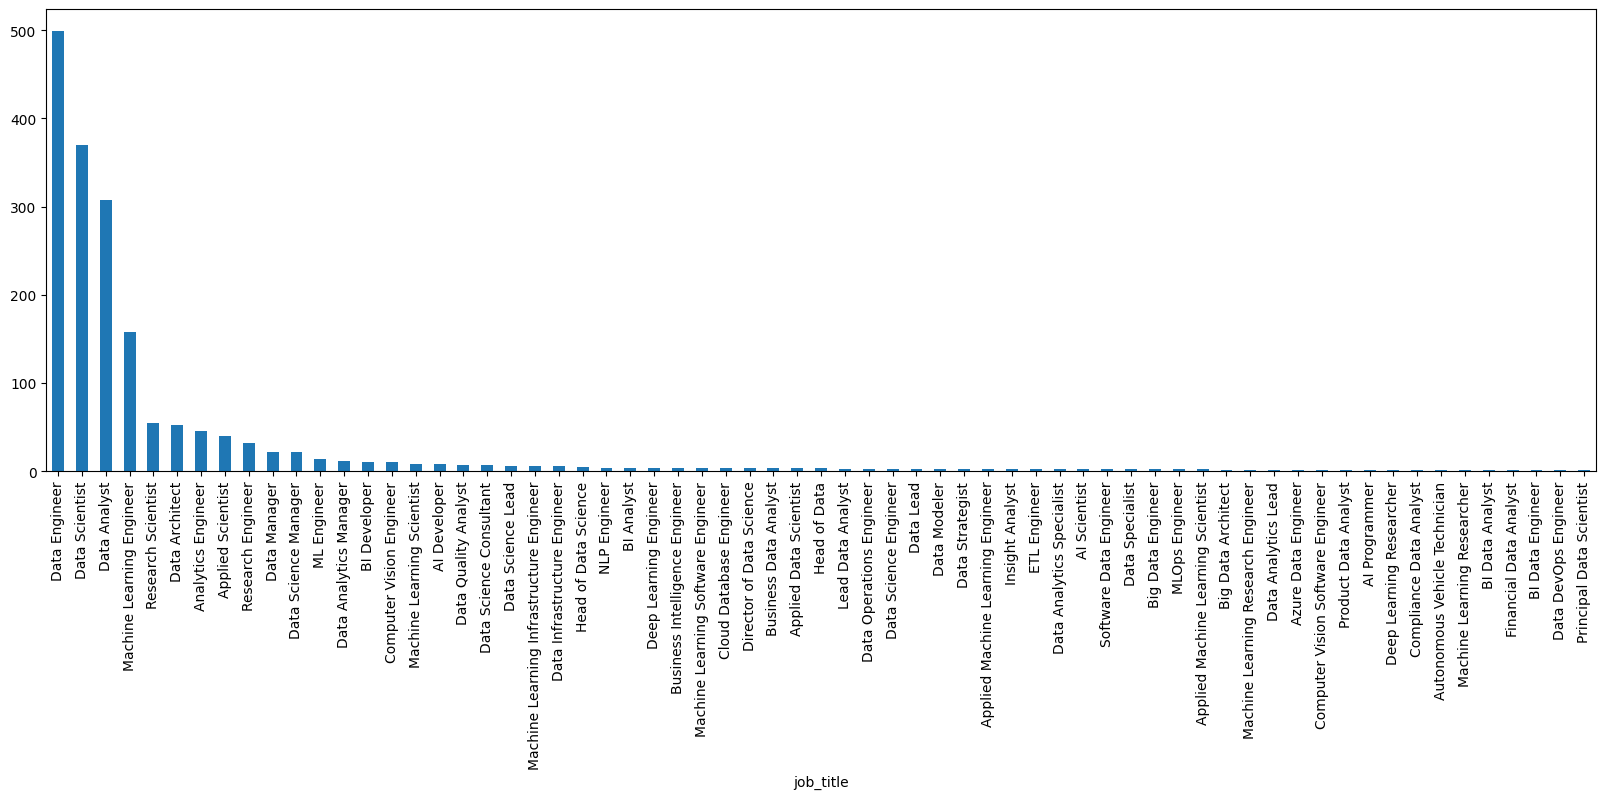

In [15]:
salary_data['job_title'].value_counts().plot(kind='bar', figsize=(20, 6))

The most mentioned jobs in the datasets are:
- Data Engineer
- Data Scientist
- Data Analyst
- Machine Learning Engineer
- Analytics Engineer
- Data Architect
- Data Science Manager
- Research Scientist

We will keep these titles and mark the rest as "Other".

But before that we need to do some text pre-processing. ML Engineer and Machine Learning Engineer are considered as two separate job titles, while it is the same. We will also replace BI with Business Intelligence to standardize the job titles.

In [16]:
salary_data['job_title'] = salary_data['job_title'].replace('ML', 'Machine Learning', regex=True)
salary_data['job_title'] = salary_data['job_title'].replace('BI', 'Business Intelligence', regex=True)
print(salary_data['job_title'])
print(salary_data['job_title'].unique())

0        Principal Data Scientist
1       Machine Learning Engineer
2       Machine Learning Engineer
3                  Data Scientist
4                  Data Scientist
                  ...            
1815    Machine Learning Engineer
1817               Data Scientist
1818               Data Scientist
1819                Data Engineer
1820                Data Engineer
Name: job_title, Length: 1785, dtype: object
['Principal Data Scientist' 'Machine Learning Engineer' 'Data Scientist'
 'Applied Scientist' 'Data Analyst' 'Data Modeler' 'Research Engineer'
 'Analytics Engineer' 'Business Intelligence Engineer' 'Data Strategist'
 'Data Engineer' 'Computer Vision Engineer' 'Data Quality Analyst'
 'Compliance Data Analyst' 'Data Architect'
 'Applied Machine Learning Engineer' 'Research Scientist'
 'Data Analytics Manager' 'Business Data Analyst' 'Applied Data Scientist'
 'ETL Engineer' 'Data DevOps Engineer' 'AI Developer' 'Head of Data'
 'Data Science Manager' 'Data Manager' 'Machine Lea

Then, we will try to group together the same job titles. For example Lead Data Scientist and Data Scientist Lead will be categorized under Data Scientist. Same with:

- Machine Learning Engineer
- Data Analyst
- Data Engineer
- AI Specialist

In [17]:
# Handle the job titles
def group_titles(title):
    if 'data scien' in title.lower():
        return 'Data Scientist'
    elif 'machine learning' in title.lower():
        return 'Machine Learning Engineer'
    elif 'data analy' in title.lower() in title.lower():
        return 'Data Analyst'
    elif 'data engineer' in title.lower():
        return 'Data Engineer'
    elif 'ai' in title.lower():
        return 'AI Specialist'
    else:
        return title

salary_data['job_title'] = salary_data['job_title'].apply(group_titles)

Display the unique values for the remaining features (excluding salary_in_usd)

In [18]:
for column in salary_data.columns:
    if column != 'salary_in_usd':
        unique_values = salary_data[column].unique()
        print(f"Unique values in column '{column}':")
        for value in unique_values:
            print(value)
        print()

Unique values in column 'experience_level':
Senior
Mid-level
Entry-level
Executive

Unique values in column 'employment_type':
Full-time
Contract
Freelance
Part-time

Unique values in column 'job_title':
Data Scientist
Machine Learning Engineer
Applied Scientist
Data Analyst
Data Modeler
Research Engineer
Analytics Engineer
Business Intelligence Engineer
Data Strategist
Data Engineer
Computer Vision Engineer
Data Quality Analyst
Data Architect
Research Scientist
ETL Engineer
Data DevOps Engineer
AI Specialist
Head of Data
Data Manager
Data Specialist
Autonomous Vehicle Technician
Cloud Database Engineer
Data Infrastructure Engineer
Data Operations Engineer
Deep Learning Researcher
Business Intelligence Analyst
Insight Analyst
Deep Learning Engineer
Big Data Architect
Computer Vision Software Engineer
Business Intelligence Developer
Data Lead
NLP Engineer

Unique values in column 'remote_ratio':
100
0
50

Unique values in column 'company_location':
ES
US
CA
DE
GB
Other
IN
FR

Unique val

#### Salary

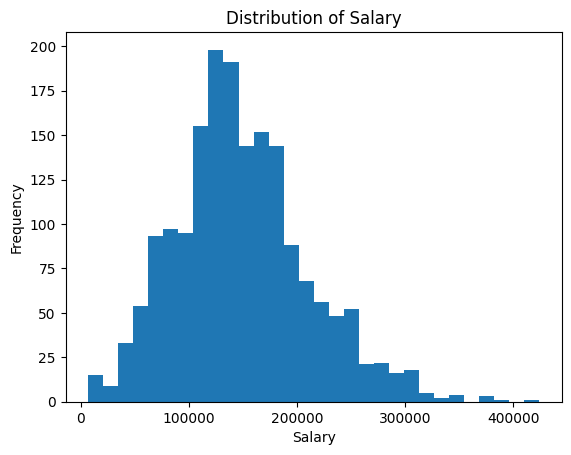

In [19]:
# Create a histogram
plt.hist(salary_data['salary_in_usd'], bins=30)

# Set labels and title
plt.xlabel('Salary')
plt.ylabel('Frequency')
plt.title('Distribution of Salary')

# Show the histogram
plt.show()

The majority of the salary in the are below 250,000 USD.

#### Visualize the relationship between salary and other variables

c:\Users\Haingo\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Haingo\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Haingo\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Haingo\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is

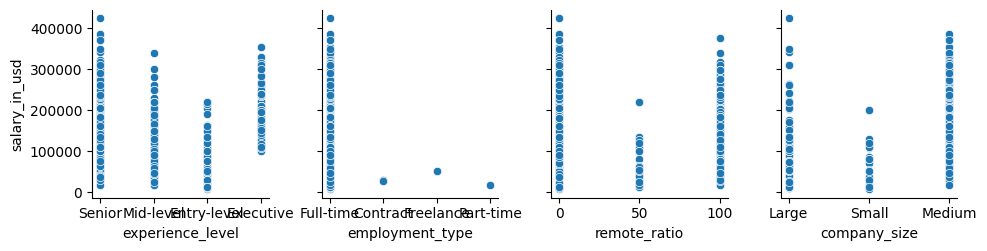

In [20]:
# Create scatter plots
sns.pairplot(salary_data, x_vars=['experience_level', 'employment_type', 'remote_ratio', 'company_size'], y_vars=['salary_in_usd'])

# Show the plots
plt.show()

1. Experience level:mostly senior-level roles are paid the highest.

1. Employment type: employees with full-time status are paid the highest.

1. Remote ratio: it appears that employees working on-site or full remote are paid higher than employees working in hybrid mode.

1. Company size: employees working in large and medium-size companies get paid higher then employees working in a small company.


### Encode categorical variables

In [21]:
salary_data.columns
# salary_data.to_csv('salary_data_cleaned.csv', index=False)

Index(['experience_level', 'employment_type', 'job_title', 'salary_in_usd',
       'remote_ratio', 'company_location', 'company_size'],
      dtype='object')

In [22]:
LE = LabelEncoder()

salary_data['experience_level_en'] = LE.fit_transform(salary_data['experience_level'])
salary_data['employment_type_en'] = LE.fit_transform(salary_data['employment_type'])
salary_data['job_title_en'] = LE.fit_transform(salary_data['job_title'])
salary_data['remote_ratio_en'] = LE.fit_transform(salary_data['remote_ratio'])
salary_data['company_location_en'] = LE.fit_transform(salary_data['company_location'])
salary_data['company_size_en'] = LE.fit_transform(salary_data['company_size'])



In [23]:
# Drop the old values
salary_data.drop(['experience_level', 'employment_type', 'job_title', 'remote_ratio', 'company_location', 'company_size'], axis=1, inplace=True)
salary_data

,salary_in_usd,experience_level_en,employment_type_en,job_title_en,remote_ratio_en,company_location_en,company_size_en
0,85847,3,2,21,2,2,0
1,30000,2,0,29,2,7,2
2,25500,2,0,29,2,7,2
3,175000,3,2,21,2,0,1
4,120000,3,2,21,2,0,1
...,...,...,...,...,...,...,...
1815,134500,3,2,29,0,7,0
1817,130000,2,2,21,0,7,1
1818,90000,2,2,21,0,7,1
1819,160000,0,2,14,0,7,1


Scale down the possible values for job_title and company_location to avoid the model from assuming that higher values are more important than lower values.

In [24]:
scaler = MinMaxScaler(feature_range=(0, 3))

# Scale down the job_title column
job_title_scaled = scaler.fit_transform(salary_data[['job_title_en']])
salary_data['job_title_en'] = job_title_scaled

# Scale down the company_location column
company_location_scaled = scaler.fit_transform(salary_data[['company_location_en']])
salary_data['company_location_en'] = company_location_scaled

salary_data
# salary_data.to_csv('salary_data_encoded.csv', index=False)

,salary_in_usd,experience_level_en,employment_type_en,job_title_en,remote_ratio_en,company_location_en,company_size_en
0,85847,3,2,1.96875,2,0.857143,0
1,30000,2,0,2.71875,2,3.000000,2
2,25500,2,0,2.71875,2,3.000000,2
3,175000,3,2,1.96875,2,0.000000,1
4,120000,3,2,1.96875,2,0.000000,1
...,...,...,...,...,...,...,...
1815,134500,3,2,2.71875,0,3.000000,0
1817,130000,2,2,1.96875,0,3.000000,1
1818,90000,2,2,1.96875,0,3.000000,1
1819,160000,0,2,1.31250,0,3.000000,1


## B) Model training

This section includes:
- AutoML exploration with AutoGluon.
- Comparing some of the models suggested by AutoGluon AutoML.
- Performing GridSearchCV on models suggested from AutoGluon AutoML.

#### Split the data into a train and test sets

We will reserve 20% of the dataset for the test set.

In [25]:
train_data = salary_data

train, test = train_test_split(train_data, test_size=0.2, random_state=42, shuffle=True)

In [26]:
print(train.head())
print(train.shape)

      salary_in_usd  experience_level_en  employment_type_en  job_title_en  \
1755         150000                    3                   2       2.90625   
178          155000                    3                   2       1.31250   
897           82920                    2                   2       1.96875   
1632         203500                    3                   2       2.71875   
488          317070                    3                   2       1.96875   

      remote_ratio_en  company_location_en  company_size_en  
1755                0                  3.0                1  
178                 0                  3.0                1  
897                 2                  3.0                1  
1632                2                  3.0                1  
488                 0                  3.0                1  
(1428, 7)


In [27]:
print(test.head())
print(test.shape)

      salary_in_usd  experience_level_en  employment_type_en  job_title_en  \
1395          81500                    3                   2       1.31250   
1096         172800                    3                   2       1.31250   
1544         156400                    3                   2       1.96875   
294          222200                    3                   2       0.18750   
1004         110000                    3                   2       1.03125   

      remote_ratio_en  company_location_en  company_size_en  
1395                0                  3.0                1  
1096                0                  3.0                1  
1544                0                  3.0                1  
294                 0                  3.0                0  
1004                0                  3.0                1  
(357, 7)


In [28]:
LABEL = 'salary_in_usd' # specifies which column do we want to predict

### 1) Using AutoGluon AutoML

### Modeling

In [29]:
EVAL_METRIC = 'root_mean_squared_error' # specifies which metric to use for validation

SAVE_PATH = 'agModels-predictSalary'  # specifies folder to store trained models from AutoGluon

#### Initializing AutoGluon's TabularPredictor

In [30]:
predictor = TabularPredictor(label=LABEL, path=SAVE_PATH, eval_metric= EVAL_METRIC)

#### Fit the predictor on the training set

In [31]:
predictor = predictor.fit(train_data=train, presets=['good_quality', 'optimize_for_deployment'])

Presets specified: ['good_quality', 'optimize_for_deployment']
Setting dynamic_stacking from 'auto' to True. Reason: Enable dynamic_stacking when use_bag_holdout is disabled. (use_bag_holdout=False)
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=1
Note: `save_bag_folds=False`! This will greatly reduce peak disk usage during fit (by ~8x), but runs the risk of an out-of-memory error during model refit if memory is small relative to the data size.
	You can avoid this risk by setting `save_bag_folds=True`.
Dynamic stacking is enabled (dynamic_stacking=True). AutoGluon will try to determine whether the input data is affected by stacked overfitting and enable or disable stacking as a consequence.
Detecting stacked overfitting by sub-fitting AutoGluon on the input data. That is, copies of AutoGluon will be sub-fit on subset(s) of the data. Then, the holdout validation data is used to detect stacked overfitting.
Sub-fit(s) time limit is: 3600 seconds.


[1000]	valid_set's rmse: 54520.6
[1000]	valid_set's rmse: 56296.1
[2000]	valid_set's rmse: 56167.2
[1000]	valid_set's rmse: 55827.9
[2000]	valid_set's rmse: 55463.2
[3000]	valid_set's rmse: 55305
[4000]	valid_set's rmse: 55213.6
[5000]	valid_set's rmse: 55142.1
[6000]	valid_set's rmse: 55128.9
[7000]	valid_set's rmse: 55107.2
[8000]	valid_set's rmse: 55095.8
[9000]	valid_set's rmse: 55106.3
[10000]	valid_set's rmse: 55104
[1000]	valid_set's rmse: 52973.4
[2000]	valid_set's rmse: 52581.4
[3000]	valid_set's rmse: 52486.6
[4000]	valid_set's rmse: 52505.5


	-52259.661	 = Validation score   (-root_mean_squared_error)
	12.58s	 = Training   runtime
	0.07s	 = Validation runtime
Fitting model: LightGBM_BAG_L1 ... Training model for up to 583.79s of the 883.92s of remaining time.
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy


[1000]	valid_set's rmse: 52684.3
[1000]	valid_set's rmse: 54189.6


	-50976.2587	 = Validation score   (-root_mean_squared_error)
	5.82s	 = Training   runtime
	0.03s	 = Validation runtime
Fitting model: RandomForestMSE_BAG_L1 ... Training model for up to 577.9s of the 878.03s of remaining time.
	-51664.8092	 = Validation score   (-root_mean_squared_error)
	0.43s	 = Training   runtime
	0.1s	 = Validation runtime
Fitting model: CatBoost_BAG_L1 ... Training model for up to 577.32s of the 877.45s of remaining time.
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	-50561.8751	 = Validation score   (-root_mean_squared_error)
	4.6s	 = Training   runtime
	0.0s	 = Validation runtime
Fitting model: ExtraTreesMSE_BAG_L1 ... Training model for up to 572.68s of the 872.81s of remaining time.
	-50956.8781	 = Validation score   (-root_mean_squared_error)
	0.37s	 = Training   runtime
	0.1s	 = Validation runtime
Fitting model: NeuralNetFastAI_BAG_L1 ... Training model for up to 572.19s of the 872.32s of remaining time.
	Fitting 8

[1000]	valid_set's rmse: 53108.8
[2000]	valid_set's rmse: 53000.2
[3000]	valid_set's rmse: 52986.1
[4000]	valid_set's rmse: 52979.9
[5000]	valid_set's rmse: 52973.3
[6000]	valid_set's rmse: 52972
[7000]	valid_set's rmse: 52970.7
[8000]	valid_set's rmse: 52969.8
[9000]	valid_set's rmse: 52969.7
[10000]	valid_set's rmse: 52969.6


	-50817.9711	 = Validation score   (-root_mean_squared_error)
	15.31s	 = Training   runtime
	0.25s	 = Validation runtime
Fitting model: WeightedEnsemble_L2 ... Training model for up to 360.0s of the 826.72s of remaining time.
	Ensemble Weights: {'ExtraTreesMSE_BAG_L1': 0.286, 'CatBoost_BAG_L1': 0.19, 'NeuralNetTorch_BAG_L1': 0.143, 'LightGBMLarge_BAG_L1': 0.143, 'LightGBMXT_BAG_L1': 0.095, 'LightGBM_BAG_L1': 0.095, 'XGBoost_BAG_L1': 0.048}
	-50235.0496	 = Validation score   (-root_mean_squared_error)
	0.02s	 = Training   runtime
	0.0s	 = Validation runtime
Fitting 9 L2 models ...
Fitting model: LightGBMXT_BAG_L2 ... Training model for up to 826.68s of the 826.67s of remaining time.
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy


[1000]	valid_set's rmse: 41814.8
[2000]	valid_set's rmse: 38736
[3000]	valid_set's rmse: 37316.3
[4000]	valid_set's rmse: 36471.9
[5000]	valid_set's rmse: 36221.9
[6000]	valid_set's rmse: 35994.6
[7000]	valid_set's rmse: 35946.1
[8000]	valid_set's rmse: 35926.1
[9000]	valid_set's rmse: 35876.7
[10000]	valid_set's rmse: 35934.7
[1000]	valid_set's rmse: 38749.8
[2000]	valid_set's rmse: 37370.1
[3000]	valid_set's rmse: 36983.9
[4000]	valid_set's rmse: 36687.1
[5000]	valid_set's rmse: 36512.1
[6000]	valid_set's rmse: 36404.8
[7000]	valid_set's rmse: 36292.5
[8000]	valid_set's rmse: 36190.3
[9000]	valid_set's rmse: 36104
[10000]	valid_set's rmse: 36013.2
[1000]	valid_set's rmse: 42739
[2000]	valid_set's rmse: 42041.8
[3000]	valid_set's rmse: 41479.1
[4000]	valid_set's rmse: 41286.9
[5000]	valid_set's rmse: 41234.5
[6000]	valid_set's rmse: 41138.5
[7000]	valid_set's rmse: 41082.1
[8000]	valid_set's rmse: 41083.4
[9000]	valid_set's rmse: 41028.9
[10000]	valid_set's rmse: 41064.4
[1000]	valid_

	-40379.6562	 = Validation score   (-root_mean_squared_error)
	41.95s	 = Training   runtime
	0.28s	 = Validation runtime
Fitting model: LightGBM_BAG_L2 ... Training model for up to 784.32s of the 784.31s of remaining time.
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy


[1000]	valid_set's rmse: 39583.5


	-41346.2355	 = Validation score   (-root_mean_squared_error)
	6.86s	 = Training   runtime
	0.03s	 = Validation runtime
Fitting model: RandomForestMSE_BAG_L2 ... Training model for up to 777.39s of the 777.38s of remaining time.
	-40348.0179	 = Validation score   (-root_mean_squared_error)
	1.49s	 = Training   runtime
	0.1s	 = Validation runtime
Fitting model: CatBoost_BAG_L2 ... Training model for up to 775.73s of the 775.72s of remaining time.
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	-40915.6747	 = Validation score   (-root_mean_squared_error)
	67.48s	 = Training   runtime
	0.05s	 = Validation runtime
Fitting model: ExtraTreesMSE_BAG_L2 ... Training model for up to 708.18s of the 708.16s of remaining time.
	-38903.1595	 = Validation score   (-root_mean_squared_error)
	0.52s	 = Training   runtime
	0.1s	 = Validation runtime
Fitting model: NeuralNetFastAI_BAG_L2 ... Training model for up to 707.5s of the 707.48s of remaining time.
	Fittin

[1000]	valid_set's rmse: 48088.7
[1000]	valid_set's rmse: 58539.5
[1000]	valid_set's rmse: 52331.5
[2000]	valid_set's rmse: 52007.5
[3000]	valid_set's rmse: 51903.8
[1000]	valid_set's rmse: 58873.8


	-52524.659	 = Validation score   (-root_mean_squared_error)
	7.36s	 = Training   runtime
	0.04s	 = Validation runtime
Fitting model: LightGBM_BAG_L1 ... Training model for up to 3344.51s of the 3344.5s of remaining time.
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	-50597.4686	 = Validation score   (-root_mean_squared_error)


[1000]	valid_set's rmse: 54580.6


	4.52s	 = Training   runtime
	0.02s	 = Validation runtime
Fitting model: RandomForestMSE_BAG_L1 ... Training model for up to 3339.92s of the 3339.91s of remaining time.
	-50856.4653	 = Validation score   (-root_mean_squared_error)
	0.44s	 = Training   runtime
	0.1s	 = Validation runtime
Fitting model: CatBoost_BAG_L1 ... Training model for up to 3339.32s of the 3339.31s of remaining time.
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	-50341.7899	 = Validation score   (-root_mean_squared_error)
	5.0s	 = Training   runtime
	0.02s	 = Validation runtime
Fitting model: ExtraTreesMSE_BAG_L1 ... Training model for up to 3334.26s of the 3334.25s of remaining time.
	-50463.6497	 = Validation score   (-root_mean_squared_error)
	0.45s	 = Training   runtime
	0.1s	 = Validation runtime
Fitting model: NeuralNetFastAI_BAG_L1 ... Training model for up to 3333.69s of the 3333.68s of remaining time.
	Fitting 8 child models (S1F1 - S1F8) | Fitting with Sequentia

[1000]	valid_set's rmse: 54018.2


	-50709.4645	 = Validation score   (-root_mean_squared_error)
	7.04s	 = Training   runtime
	0.04s	 = Validation runtime
Fitting model: WeightedEnsemble_L2 ... Training model for up to 360.0s of the 3279.8s of remaining time.
	Ensemble Weights: {'ExtraTreesMSE_BAG_L1': 0.44, 'LightGBM_BAG_L1': 0.2, 'CatBoost_BAG_L1': 0.2, 'NeuralNetTorch_BAG_L1': 0.12, 'LightGBMXT_BAG_L1': 0.04}
	-49942.5267	 = Validation score   (-root_mean_squared_error)
	0.02s	 = Training   runtime
	0.0s	 = Validation runtime
AutoGluon training complete, total runtime = 72.26s ... Best model: "WeightedEnsemble_L2"
Automatically performing refit_full as a post-fit operation (due to `.fit(..., refit_full=True)`
Refitting models via `predictor.refit_full` using all of the data (combined train and validation)...
	Models trained in this way will have the suffix "_FULL" and have NaN validation score.
	This process is not bound by time_limit, but should take less time than the original `predictor.fit` call.
	To learn more, 

AutoGluon 

#### Retrieve the performance of the fitted models

The code below will output information about the models produced during fit() 

In [32]:
predictor.leaderboard()

,model,score_val,eval_metric,pred_time_val,fit_time,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,ExtraTreesMSE_BAG_L1_FULL,None,root_mean_squared_error,0.100009,0.447371,0.100009,0.447371,1,True,4
1,WeightedEnsemble_L2_FULL,None,root_mean_squared_error,NaN,5.255664,NaN,0.024073,2,True,6
2,NeuralNetTorch_BAG_L1_FULL,None,root_mean_squared_error,NaN,4.062328,NaN,4.062328,1,True,5
3,LightGBM_BAG_L1_FULL,None,root_mean_squared_error,NaN,0.225914,NaN,0.225914,1,True,2
4,LightGBMXT_BAG_L1_FULL,None,root_mean_squared_error,NaN,0.265331,NaN,0.265331,1,True,1
5,CatBoost_BAG_L1_FULL,None,root_mean_squared_error,NaN,0.230647,NaN,0.230647,1,True,3


Based on the above result:
- `ExtraTreesMSE_BAG_L1	` is the model that can infer and has a given prediction time (pred_time_val).

#### Evaluating the model

The following code retrieves the model leaderboard using the test data.

In [33]:
test_leaderboard = predictor.leaderboard(test, silent=True, extra_info=True)
test_leaderboard

,model,score_test,score_val,eval_metric,pred_time_test,pred_time_val,fit_time,pred_time_test_marginal,pred_time_val_marginal,fit_time_marginal,...,hyperparameters,hyperparameters_fit,ag_args_fit,features,compile_time,child_hyperparameters,child_hyperparameters_fit,child_ag_args_fit,ancestors,descendants
0,CatBoost_BAG_L1_FULL,-51536.570781,None,root_mean_squared_error,0.000000,NaN,0.230647,0.000000,NaN,0.230647,...,"{'use_orig_features': True, 'max_base_models':...",{},"{'max_memory_usage_ratio': 1.15, 'max_time_lim...","[experience_level_en, remote_ratio_en, company...",None,"{'iterations': 235, 'learning_rate': 0.05, 'ra...",{'iterations': 235},"{'max_memory_usage_ratio': 1.0, 'max_time_limi...",[],[WeightedEnsemble_L2_FULL]
1,ExtraTreesMSE_BAG_L1_FULL,-51783.804599,None,root_mean_squared_error,0.102398,0.100009,0.447371,0.102398,0.100009,0.447371,...,"{'use_orig_features': True, 'max_base_models':...",{},"{'max_memory_usage_ratio': 1.0, 'max_time_limi...","[experience_level_en, remote_ratio_en, company...",None,"{'n_estimators': 300, 'max_leaf_nodes': 15000,...",{'n_estimators': 300},"{'max_memory_usage_ratio': 1.0, 'max_time_limi...",[],[WeightedEnsemble_L2_FULL]
2,WeightedEnsemble_L2_FULL,-51800.906040,None,root_mean_squared_error,0.150420,NaN,5.255664,0.010009,NaN,0.024073,...,"{'use_orig_features': False, 'max_base_models'...",{},"{'max_memory_usage_ratio': 1.0, 'max_time_limi...","[LightGBMXT_BAG_L1, CatBoost_BAG_L1, ExtraTree...",None,"{'ensemble_size': 25, 'subsample_size': 1000000}",{'ensemble_size': 25},"{'max_memory_usage_ratio': 1.0, 'max_time_limi...","[LightGBM_BAG_L1_FULL, ExtraTreesMSE_BAG_L1_FU...",[]
3,LightGBM_BAG_L1_FULL,-52431.393701,None,root_mean_squared_error,0.009997,NaN,0.225914,0.009997,NaN,0.225914,...,"{'use_orig_features': True, 'max_base_models':...",{},"{'max_memory_usage_ratio': 1.15, 'max_time_lim...","[experience_level_en, remote_ratio_en, company...",None,"{'learning_rate': 0.05, 'num_boost_round': 255}",{'num_boost_round': 255},"{'max_memory_usage_ratio': 1.0, 'max_time_limi...",[],[WeightedEnsemble_L2_FULL]
4,LightGBMXT_BAG_L1_FULL,-55746.609141,None,root_mean_squared_error,0.020005,NaN,0.265331,0.020005,NaN,0.265331,...,"{'use_orig_features': True, 'max_base_models':...",{},"{'max_memory_usage_ratio': 1.15, 'max_time_lim...","[experience_level_en, remote_ratio_en, company...",None,"{'learning_rate': 0.05, 'extra_trees': True, '...",{'num_boost_round': 865},"{'max_memory_usage_ratio': 1.0, 'max_time_limi...",[],[WeightedEnsemble_L2_FULL]
5,NeuralNetTorch_BAG_L1_FULL,-55811.085542,None,root_mean_squared_error,0.008011,NaN,4.062328,0.008011,NaN,4.062328,...,"{'use_orig_features': True, 'max_base_models':...",{},"{'max_memory_usage_ratio': 1.15, 'max_time_lim...","[experience_level_en, remote_ratio_en, company...",None,"{'num_epochs': 36, 'epochs_wo_improve': 20, 'a...","{'batch_size': 64, 'num_epochs': 0}","{'max_memory_usage_ratio': 1.0, 'max_time_limi...",[],[WeightedEnsemble_L2_FULL]


Overall, the model `ExtraTreesMSE_BAG_L1` appears to be best fit for this project.

### Making predictions with the test data

The best model chosen by AutoGluon is used to make predictions with unseen data.

In [34]:
y_pred = predictor.predict(test.drop(LABEL, axis=1))
y_pred.head()

1395    155957.09375
1096    155957.09375
1544    169513.06250
294     185996.40625
1004    134441.81250
Name: salary_in_usd, dtype: float32

In [35]:
test['salary_in_usd'].head()

1395     81500
1096    172800
1544    156400
294     222200
1004    110000
Name: salary_in_usd, dtype: int64

#### Accuracy scores from the predictions

In [36]:
perf = predictor.evaluate_predictions(y_true=test[LABEL], y_pred=y_pred)
perf

{'root_mean_squared_error': -51800.90604021969,
 'mean_squared_error': -2683333866.587669,
 'mean_absolute_error': -40554.178297881655,
 'r2': 0.31395823231556785,
 'pearsonr': 0.5704971672341648,
 'median_absolute_error': -33888.140625}

### 2) Using other libraries

Some of the models proposed by AutoGluon were:
- Cat boost
- ExtraTrees
- LightGBM
- NeuralNetTorch
- XGBoost

We will instantiate these models and fine-tune them using GridSearchCV.

Dropping the labels in the train and test sets.

In [37]:
X_train = train.drop(LABEL, axis=1)
y_train = train[LABEL]
X_test = test.drop(LABEL, axis=1)
y_test = test[LABEL]

Initializing and training the models

In [38]:
cat = CatBoostRegressor(verbose=0) # disable output logs
extra = ExtraTreesRegressor()
lgbm = LGBMRegressor()
xgb = XGBRegressor()

# Train the models
cat.fit(X_train, y_train)
extra.fit(X_train, y_train)
lgbm.fit(X_train, y_train)
xgb.fit(X_train, y_train)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000077 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 39
[LightGBM] [Info] Number of data points in the train set: 1428, number of used features: 5
[LightGBM] [Info] Start training from score 147964.705882
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

## Evaluate the models

In [39]:
# Use the models to make predictions on the test set
preds_cat = cat.predict(X_test)
preds_extra = extra.predict(X_test)
preds_lgbm = lgbm.predict(X_test)
preds_xgb = xgb.predict(X_test)

# Calculate the RMSE for each model
rmse_cat = np.sqrt(mean_squared_error(y_test, preds_cat))
rmse_extra = np.sqrt(mean_squared_error(y_test, preds_extra))
rmse_lgbm = np.sqrt(mean_squared_error(y_test, preds_lgbm))
rmse_xgb = np.sqrt(mean_squared_error(y_test, preds_xgb))

print(f'CatBoost RMSE: {rmse_cat}')
print(f'ExtraTrees RMSE: {rmse_extra}')
print(f'LightGBM RMSE: {rmse_lgbm}')
print(f'XGBoost RMSE: {rmse_xgb}')

CatBoost RMSE: 51898.47435211445
ExtraTrees RMSE: 52265.134041701305
LightGBM RMSE: 52537.04204445135
XGBoost RMSE: 52456.783200064376


From the result above, the model with the best (lowest) RMSE is the `CatBoost` model followed by the `ExtraTrees` model, the `XGBoost` model, and finally the `LightGBM` model.

#### Hyperparamater tuning

GridSearchCV will be used to retrieve the best parameters and best score of the above models using the best_params_ and best_score_ attributes. These values represent the hyperparameters that resulted in the highest performance on the evaluation metric during the grid search.

- Catboost model

In [40]:
cat_params = {'depth': [6, 8, 10], 'learning_rate': [0.01, 0.05, 0.1]}

cat_gs = GridSearchCV(cat, cat_params, error_score='raise', cv=3)
cat_gs.fit(X_train, y_train)

print(cat_gs.best_score_)
print(cat_gs.best_params_)
# # {'depth': 10, 'learning_rate': 0.01}

0.3047626874670537
{'depth': 10, 'learning_rate': 0.01}


- ExtraTrees

In [41]:
extra_params = {'n_estimators': range(10, 300, 50), 
                'criterion': ['friedman_mse', 'squared_error', 'absolute_error', 'poisson'], 
                'max_features': [None, 'sqrt', 'log2']
                }

extra_gs = GridSearchCV(extra, extra_params, error_score='raise', cv=3)
extra_gs.fit(X_train, y_train)

print(extra_gs.best_score_)
print(extra_gs.best_params_)
# #{'criterion': 'friedman_mse', 'max_features': 'sqrt', 'n_estimators': 110}

0.2970098158477183
{'criterion': 'squared_error', 'max_features': 'log2', 'n_estimators': 60}


- LightGBM

In [42]:
lgbm_params = {'num_leaves': [31, 127], 'reg_alpha': [0.1, 0.5], 'min_data_in_leaf': [30, 50, 100, 300, 400]}

lgbm_gs = GridSearchCV(lgbm, lgbm_params, error_score='raise', cv=3)
lgbm_gs.fit(X_train, y_train)

print(lgbm_gs.best_score_)
print(lgbm_gs.best_params_)
# # {'min_data_in_leaf': 30, 'num_leaves': 31, 'reg_alpha': 0.5}

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000164 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 37
[LightGBM] [Info] Number of data points in the train set: 952, number of used features: 5
[LightGBM] [Info] Start training from score 146502.855042
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positi

- XGBoost

In [43]:
xgb_params = {'n_estimators': range(10, 300, 10), 'max_depth': [6, 10, 15, 20]}

xgb_gs = GridSearchCV(xgb, xgb_params, error_score='raise', cv=3)
xgb_gs.fit(X_train, y_train)

print(xgb_gs.best_score_)
print(xgb_gs.best_params_)
# # {'max_depth': 6, 'n_estimators': 10}

0.29667579651469134
{'max_depth': 6, 'n_estimators': 10}


Training the models with the optimized parameters

In [44]:
cat_grid = CatBoostRegressor(depth=10, learning_rate=0.01, verbose=0)
extra_grid = ExtraTreesRegressor(criterion='friedman_mse', max_features='sqrt', n_estimators=110)
lgbm_grid = LGBMRegressor(min_data_in_leaf=30, num_leaves=31, reg_alpha=0.5)
xgb_grid = XGBRegressor(max_depth=6, n_estimators=10)

# Train the models
cat_grid.fit(X_train, y_train)
extra_grid.fit(X_train, y_train)
lgbm_grid.fit(X_train, y_train)
xgb_grid.fit(X_train, y_train)

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000081 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 39
[LightGBM] [Info] Number of data points in the train set: 1428, number of used features: 5
[LightGBM] [Info] Start training from score 147964.705882
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=10, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [45]:
# Use the models to make predictions on the test set
preds_cat_grid = cat_grid.predict(X_test)
preds_extra_grid = extra_grid.predict(X_test)
preds_lgbm_grid = lgbm_grid.predict(X_test)
preds_xgb_grid = xgb_grid.predict(X_test)

# Calculate the RMSE for each model
rmse_cat_grid = np.sqrt(mean_squared_error(y_test, preds_cat_grid))
rmse_extra_grid = np.sqrt(mean_squared_error(y_test, preds_extra_grid))
rmse_lgbm_grid = np.sqrt(mean_squared_error(y_test, preds_lgbm_grid))
rmse_xgb_grid = np.sqrt(mean_squared_error(y_test, preds_xgb_grid))

print(f'CatBoost RMSE: {rmse_cat_grid}')
print(f'ExtraTrees RMSE: {rmse_extra_grid}')
print(f'LightGBM RMSE: {rmse_lgbm_grid}')
print(f'XGBoost RMSE: {rmse_xgb_grid}')

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
CatBoost RMSE: 51182.55613465364
ExtraTrees RMSE: 51808.612171974426
LightGBM RMSE: 52524.29767272556
XGBoost RMSE: 52007.96550328349


`CatBoost` remains the model with the best RMSE value of around 51183.

# D) Model deployment

Create a pickle file from the catboost (after GridSearchCV) model

In [46]:
import pickle

# Save the cat_grid model to a file
with open('model.pkl', 'wb') as file:
    pickle.dump(cat_grid, file)

Saving the data columns in a pkl file

In [47]:
import joblib

model_Columns = list(X_train.columns)
joblib.dump(model_Columns, 'model_columns.pkl')
print("Models columns dumped!")

Models columns dumped!
